# Кредитный скоринг

In [1]:
import pandas as pd
import numpy as np
from statsmodels.stats.weightstats import _tconfint_generic
from statsmodels.stats import proportion
from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import scipy
import matplotlib.pyplot as plt

In C:\Users\Sandra\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\Users\Sandra\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\Users\Sandra\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [2]:
data=pd.read_csv('data/credit_card_default_analysis.csv', sep=',')
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


Датасет содержит данные о кредитных историях клиентов одного из банков. Поля в предоставляемых данных имеют следующий смысл:

* LIMIT_BAL: размер кредитного лимита (в том числе и на семью клиента);
* SEX: пол клиента (1 = мужской, 2 = женский );
* EDUCATION: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных );
* MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных);
* AGE: возраст в годах;
* PAY_0 - PAY_6 : История прошлых платежей по кредиту. PAY_6 - платеж в апреле, ... Pay_0 - платеж в сентябре. Платеж = (0 = исправный платеж, 1=задержка в один месяц, 2=задержка в 2 месяца ...);
* BILL_AMT1 - BILL_AMT6: задолженность, BILL_AMT6 - на апрель, BILL_AMT1 - на сентябрь;
* PAY_AMT1 - PAY_AMT6: сумма уплаченная в PAY_AMT6 - апреле, ..., PAY_AMT1 - сентябре;
* default - индикатор невозврата денежных средств.

По предоставленным историческим данным необходимо оценить влияние определенных признаков на способность заемщика вернуть кредит - на значение переменной _default_.

Для начала посмотрим на сбалансированность _default_. 

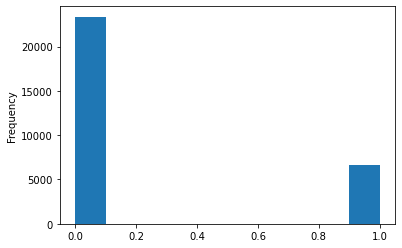

In [3]:
data.default.plot.hist()

## 1. Влияние размера кредитного лимита (_LIMIT_BALL_)

Начнем наше исследование с изучения влияния на целевую переменную размера кредитног лимита - т.е. влияния _LIMIT_BALL_.

Text(0, 0.5, 'Количество заемщиков')

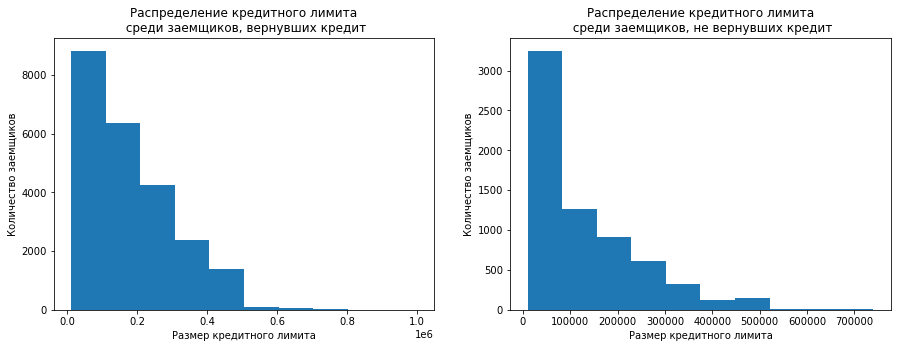

In [4]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.hist(data[data['default']==0].LIMIT_BAL)
plt.title('Распределение кредитного лимита\n среди заемщиков, вернувших кредит')
plt.xlabel('Размер кредитного лимита')
plt.ylabel('Количество заемщиков')
plt.subplot(122)
plt.hist(data[data['default']==1].LIMIT_BAL)
plt.title('Распределение кредитного лимита\n среди заемщиков, не вернувших кредит')
plt.xlabel('Размер кредитного лимита')
plt.ylabel('Количество заемщиков')

Оба распределения сильно скошены и отличаются от нормального, что не дает нам право использовать критерии Стьюдента.

Посмотрим на точечную оценку выборочной медианы размера кридитного лимита для лиц, не имеющих кредитных задолженностей:

In [5]:
med0=data[data['default']==0].LIMIT_BAL.median()
print('Выборочная медиана размера кредитного лимита для лиц, не имеющих задолженностей: ', med0)

Выборочная медиана размера кредитного лимита для лиц, не имеющих задолженностей:  150000.0


Сделаем то же самое для лиц, у которых наблюдаются задолженности.

In [6]:
med1=data[data['default']==1].LIMIT_BAL.median()
print('Выборочная медиана размера кредитного лимита для лиц, имеющих задолженности: ', med1)

Выборочная медиана размера кредитного лимита для лиц, имеющих задолженности:  90000.0


Посмотрим на точечную оценку их разности:

In [7]:
print('Выборочная оценка разности медиан размера кредитного лимита для лиц без задолженностей и \
имеющих задолженности: %.4f'%(med0-med1))

Выборочная оценка разности медиан размера кредитного лимита для лиц без задолженностей и имеющих задолженности: 60000.0000


Построим доверительный интервал для этой разности на основе бутстрапированных выборок.

In [8]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [9]:
def stat_intervals(stat, alpha):
    boundaries = np.quantile(stat, [alpha / 2., (1 - alpha / 2.)])
    return (boundaries[0], boundaries[1])

In [10]:
median_limit_default0=list(map(np.median, get_bootstrap_samples(data[data['default']==0].LIMIT_BAL.values,1000)))
median_limit_default1=list(map(np.median, get_bootstrap_samples(data[data['default']==1].LIMIT_BAL.values,1000)))
delta_median_limit=list(map(lambda x: x[0]-x[1], \
                            zip(median_limit_default0, median_limit_default1)))
print('95%% доверительный интервал для разности медиан:[%.4f, %.4f]'%stat_intervals(delta_median_limit,0.05))

95% доверительный интервал для разности медиан:[60000.0000, 70000.0000]


Видим, что полученный интервал лежит справа от нуля, что дает уверенность в том, что медианное значение кредитного лимита среди людей, не имеющих задолженностей, больше, чем среди тех, у кого наблюдается задолженность. Этот результат имеет практическую значимость.

Проверим гипотезу о равенстве медианных значений по этим двум подвыборкам.

$H_0$: медианные значения кредитного лимита для этих двух подвыборок равны.

$H_1$: не равны.

Необходимые подвыборки независимые, поэтому для проверки данной гипотезы будем использовать двухвыборочный критерий знаковых рангов (Манна-Уитни).

In [11]:
stats.mannwhitneyu(data[data['default']==0].LIMIT_BAL,data[data['default']==1].LIMIT_BAL, alternative='two-sided')

MannwhitneyuResult(statistic=95786286.5, pvalue=1.2255485818223303e-189)

Достигаемый уровень значимости очень мал, что позволяет с увереностью отвергнуть нулевую гипотезу в пользу двусторонней альтернативы.

## 2. Влияние пола (_SEX_)

В наших данных признак _SEX_ является категориальным, заменим его бинарным признаком _FEMALE_.

In [12]:
data['female']=data.SEX.apply(lambda x: 0 if x==1 else 1)
data.drop('SEX', axis=1, inplace=True)

Text(0, 0.5, 'Количество заемщиков')

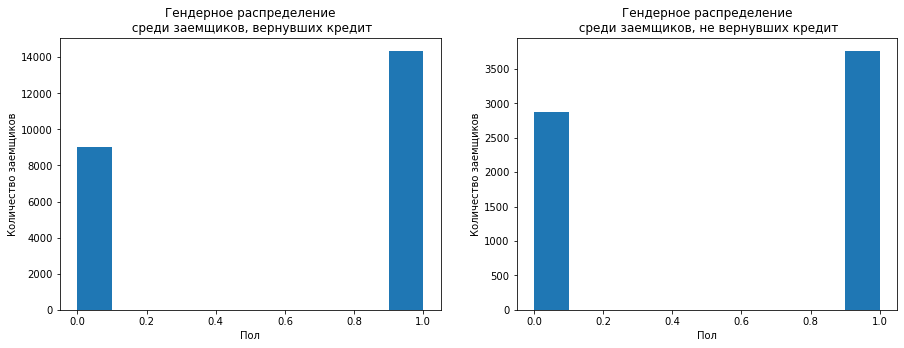

In [13]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.hist(data[data['default']==0].female)
plt.title('Гендерное распределение\n среди заемщиков, вернувших кредит')
plt.xlabel('Пол')
plt.ylabel('Количество заемщиков')
plt.subplot(122)
plt.hist(data[data['default']==1].female)
plt.title('Гендерное распределение\n среди заемщиков, не вернувших кредит')
plt.xlabel('Пол')
plt.ylabel('Количество заемщиков')

По графикам видно, что гендерное соотношение в подвыборках похоже, однако визуально среди не вернувших кредит доля мужчин больше. Проверим это с помощью интервальной оценки разности долей женщин в обеих подвыборках.

In [14]:
n_fem0=np.sum(data[data['default']==0].female)
n_fem1=np.sum(data[data['default']==1].female)
frac_fem_default0=n_fem0/data[data['default']==0].female.shape[0]
frac_fem_default1=n_fem1/data[data['default']==1].female.shape[0]
print('Выборочная доля женщин среди не имеющих задолженности: ',frac_fem_default0)
print('Выборочная доля женщин среди имеющих задолженности: ',frac_fem_default1)
print('Точечная оценка разности долей женщин: ',frac_fem_default0-frac_fem_default1)

Выборочная доля женщин среди не имеющих задолженности:  0.6141499743194658
Выборочная доля женщин среди имеющих задолженности:  0.5670584689572031
Точечная оценка разности долей женщин:  0.0470915053622627


In [15]:
interval=proportion.confint_proportions_2indep(n_fem0, data[data['default']==0].female.shape[0], \
                                      n_fem1, data[data['default']==1].female.shape[0])
print('95%% доверительный интервал для разности долей женщин в обеих подвыборках: [%.4f, %.4f]'%interval)

95% доверительный интервал для разности долей женщин в обеих подвыборках: [0.0337, 0.0606]


Доверительный интервал лежит справа от нуля, что говорит с 95% вероятностью о том, что доля женщин среди вернувших кредит больше, чем среди женщин с задолженностями. Из этого же следует, что доля мужчин, среди имеющих задолженности, больше, чем среди не имеющих.

Проверим результат с помощью статистического критерия - двухвыборочного z-критерия для доли для независимых выборок.

$H_0$: доли женщин в обоих подвыборках одинаковы.

$H_1$: доли женщин отличаются. Альтернативная гипотеза выбирается в данном случае двусторонней, так как она должна выбираться только на основе логических предположений, а не исходя из данных. Так как у нас нет логических оснований предполагать уменьшение или увеличение доли женщин в одной из подвыборок, то и было принято решение проверять просто неравенство двух этих долей.

In [16]:
stat=proportion.test_proportions_2indep(n_fem0, data[data['default']==0].female.shape[0], \
                                      n_fem1, data[data['default']==1].female.shape[0], method='wald')
print('p-value для нулевой гипотезы о равенстве долей женщин в обеих подвыборках: ',stat[1])

p-value для нулевой гипотезы о равенстве долей женщин в обеих подвыборках:  6.9379488648039966e-12


Достигаемый уровень значимости очень мал, благодаря чему мы можем отвергнуть нулевую гипотезу в пользу двусторонней альтернативы.

In [17]:
#в реализации функции proportion.test_proportion_2indep() z-статистика вычисляется не совсем так, как это давалось в лекциях,
#поэтому на всякий случай для проверки данных гипотез были использованы и пользовательские функции,которые также выдают
#p-value, позволяющий отвергнуть нулевую гипотезу в пользу двусторонней альтернативы. 
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)
    
print("p-value: ",proportions_diff_z_test(proportions_diff_z_stat_ind(data[data['default']==0].female, \
                                                                          data[data['default']==1].female)))


p-value:  4.472866521609831e-12


## 3. Влияние образования (_EDUCATION_)

Text(0, 0.5, 'Количество заемщиков')

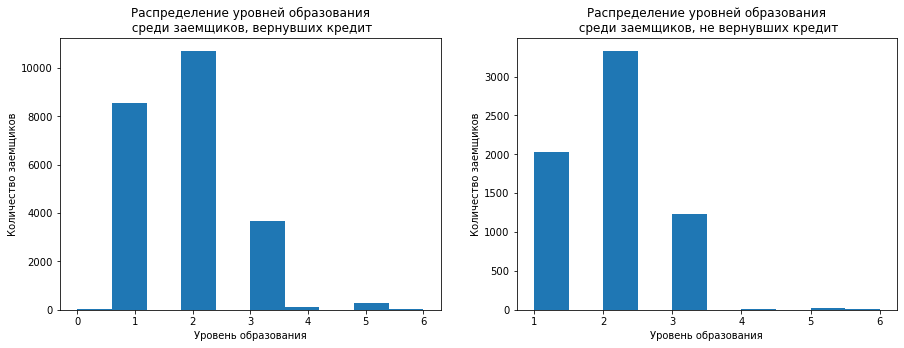

In [18]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.hist(data[data['default']==0].EDUCATION)
plt.title('Распределение уровней образования\n среди заемщиков, вернувших кредит')
plt.xlabel('Уровень образования')
plt.ylabel('Количество заемщиков')
plt.subplot(122)
plt.hist(data[data['default']==1].EDUCATION)
plt.title('Распределение уровней образования\n среди заемщиков, не вернувших кредит')
plt.xlabel('Уровень образования')
plt.ylabel('Количество заемщиков')

In [19]:
data[data['default']==0].EDUCATION.value_counts()

2    10700
1     8549
3     3680
5      262
4      116
6       43
0       14
Name: EDUCATION, dtype: int64

In [20]:
data[data['default']==1].EDUCATION.value_counts()

2    3330
1    2036
3    1237
5      18
6       8
4       7
Name: EDUCATION, dtype: int64

Видим, что в обеих подвыборках преобладает доля людей с уровнем образования "2". При этом в той и другой подвыборках присутсвует относительно мало людей с уровнями образования "4", "5", "6". Люди с уровнем образования "0" присутствуют только среди вернувших кредит.

Проверим гипотезу о том, что образование не влияет на то, вернет ли человек долг.

Взаимосвязь интересующих нас признаков (_default_ и _EDUCATION_) будем проверять с помощью коэффициента корреляции. Так как признак _EDUCATION_ является категориальным, а признак _default_ бинарным, то корреляция вычисляется с помощью коэффициента Крамера. Данный коэффициент вычисляется на основе таблицы сопряженности, где каждый элемент $a_{ij}$ означает количество элементов, для которых признак _EDUCATION_ принимает значение _j_, а признак _default_ принимает значение _i_.

In [21]:
contingency_table_edu=pd.crosstab(data.EDUCATION, data.default)
print(contingency_table_edu)

default        0     1
EDUCATION             
0             14     0
1           8549  2036
2          10700  3330
3           3680  1237
4            116     7
5            262    18
6             43     8


In [22]:
k1=data.EDUCATION.unique().shape[0]
k2=data.default.unique().shape[0]
v_cramer=np.sqrt(stats.chi2_contingency(contingency_table_edu)[0]/(data.shape[0]*(np.min([k1,k2])-1)))
print('Коэффициент Крамера для данной таблицы сопряженности: %g'%v_cramer)

Коэффициент Крамера для данной таблицы сопряженности: 0.0737601


Значимость полученного коэффициента корреляции проверим с помощью критерия $\chi^2$ с числом степеней свободы (k1-1)(k2-1).

$H_0$: образование не влияет на возврат долга (коэффициент V Крамера равен нулю).

$H_1$: образование влияет на возврат долга (коэффициент V Крамера отличен от нуля).

In [23]:
print('Достигаемый уровень значимости %g'%stats.chi2_contingency(contingency_table_edu)[1])

Достигаемый уровень значимости 1.23326e-32


p-value очень мал, поэтому нулевая гипотеза о незначимости образования для определения значения _default_ отвергается в пользу двусторонней альтернативы.

In [24]:
expected=np.floor(stats.chi2_contingency(contingency_table_edu)[3])
expected=np.array([list(map(int,x)) for x in expected])
expected

array([[   10,     3],
       [ 8243,  2341],
       [10926,  3103],
       [ 3829,  1087],
       [   95,    27],
       [  218,    61],
       [   39,    11]])

In [25]:
def new_table(contingency_table,exp):
    dif0=contingency_table[0].values-exp[:,0]
    dif1=contingency_table[1].values-exp[:,1]
    df=pd.DataFrame({'real_0': contingency_table[0],
                    'real_1': contingency_table[1],
                    'exp_0': exp[:,0],
                    'exp_1': exp[:,1],
                    'dif_0': dif0,
                    'dif_1': dif1})
    return df
    
results=new_table(contingency_table_edu,expected)
results

,real_0,real_1,exp_0,exp_1,dif_0,dif_1
EDUCATION,,,,,,
0,14,0,10,3,4,-3
1,8549,2036,8243,2341,306,-305
2,10700,3330,10926,3103,-226,227
3,3680,1237,3829,1087,-149,150
4,116,7,95,27,21,-20
5,262,18,218,61,44,-43
6,43,8,39,11,4,-3


Видно, что колонки _dif_0_ и _dif_1_ имеют почти одинаковые значения по модулю и противоположны по знаку.

Для масштабирования таблицы можно применить процедуру стандартизации: она осуществляется посредством вычета из каждого признака среднего значения и нормировки на стандартное отклонение.

In [26]:
results.apply(lambda col: (col-col.mean())/col.std(),axis=0)

,real_0,real_1,exp_0,exp_1,dif_0,dif_1
EDUCATION,,,,,,
0,-0.733431,-0.717514,-0.731613,-0.731304,0.020410,-0.020410
1,1.149954,0.823476,1.078761,1.078817,1.818158,-1.818158
2,1.624607,1.802867,1.668732,1.668770,-1.348736,1.348736
3,0.075531,0.218736,0.108156,0.107948,-0.890370,0.890370
4,-0.710923,-0.712216,-0.712923,-0.712722,0.121607,-0.121607
5,-0.678706,-0.703890,-0.685876,-0.686399,0.258522,-0.258522
6,-0.727032,-0.711459,-0.725237,-0.725110,0.020410,-0.020410


Наиболее сильно выраженные значения имеют уровни образования "1", "2" и "3".

Получается, что образование уровня "1" является индикатором того, что реальное количество людей, вернувших кредит, больше, чем их ожидаемое значение, и наоборот для должников. То есть этот уровень образования является хорошим показателем, он может в какой-то степени гарантировать добросовестность заемщика. 

Образование уровня "2" говорит о том, что реальное количество заемщиков, вернувших кредит, было меньше, чем их ожидаемое значение, а реальное количество должников - больше по сравнению с предсказанием для них. Значит, можно считать этот уровень образования - отрицательным показателем для выдачи кредита. 

Аналогично рассуждая об уровне "3", делаем вывод, что это также "плохой" уровень образования для выдачи кредита.

Тогда в последующей модели логистической регрессии для вынесения вердикта о выдаче или невыдаче кредита можно поставить уровню образования "1" положительный коэффициент, уровням "2" и "3" - отрицательные, где коэффициент для "2" будет больше по модулю.

## 4. Влияние семейного положения (_MARRIAGE_)

Text(0, 0.5, 'Количество заемщиков')

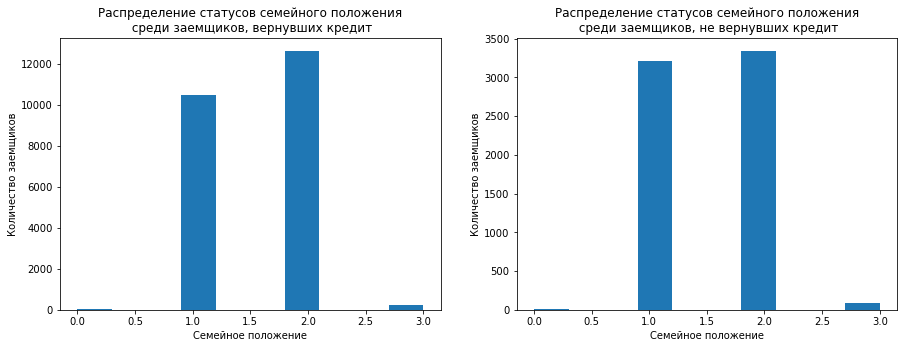

In [27]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.hist(data[data['default']==0].MARRIAGE)
plt.title('Распределение статусов семейного положения\n среди заемщиков, вернувших кредит')
plt.xlabel('Семейное положение')
plt.ylabel('Количество заемщиков')
plt.subplot(122)
plt.hist(data[data['default']==1].MARRIAGE)
plt.title('Распределение статусов семейного положения\n среди заемщиков, не вернувших кредит')
plt.xlabel('Семейное положение')
plt.ylabel('Количество заемщиков')

По графикам видно, что соотношение разных семейных статусов в обеих подвыборках очень похоже.

Ситуация с признаком _MARRIAGE_ аналогична пункту 3 - снова имеем категориальный и бинарный признаки. Составим для них таблицу сопряженности, посчитаем коэффициент Крамера и определим его статистическую значимость с помощью критерия $\chi^2_{(k1-1)(k2-1)}$.

In [28]:
contingency_table_marriage=pd.crosstab(data.MARRIAGE, data.default)
print(contingency_table_marriage)

default       0     1
MARRIAGE             
0            49     5
1         10453  3206
2         12623  3341
3           239    84


In [29]:
k1=data.MARRIAGE.unique().shape[0]
k2=data.default.unique().shape[0]
v_cramer=np.sqrt(stats.chi2_contingency(contingency_table_marriage)[0]/(data.shape[0]*(np.min([k1,k2])-1)))
print('Коэффициент Крамера для данной таблицы сопряженности: %g'%v_cramer)

Коэффициент Крамера для данной таблицы сопряженности: 0.0344782


$H_0$: семейное положение не влияет на возврат долга (коэффициент V Крамера равен нулю).

$H_1$: семейное положение влияет на возврат долга (коэффициент V Крамера не равен нулю).

In [30]:
print('Достигаемый уровень значимости %g'%stats.chi2_contingency(contingency_table_marriage)[1])

Достигаемый уровень значимости 8.82586e-08


Полученный p-value позволяет отвергнуть нулевую гипотезу в пользу двусторонней альтернативы.

## 5. Влияние возраста (_AGE_)

Text(0, 0.5, 'Количество заемщиков')

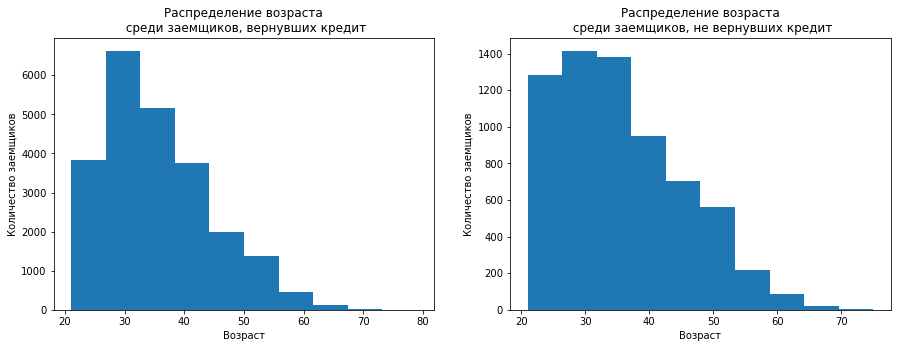

In [31]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.hist(data[data['default']==0].AGE)
plt.title('Распределение возраста\n среди заемщиков, вернувших кредит')
plt.xlabel('Возраст')
plt.ylabel('Количество заемщиков')
plt.subplot(122)
plt.hist(data[data['default']==1].AGE)
plt.title('Распределение возраста\n среди заемщиков, не вернувших кредит')
plt.xlabel('Возраст')
plt.ylabel('Количество заемщиков')

Оба распределения не являются нормальными, поэтому для проверки гипотез о них нужно использовать непараметрические критерии.

Сначала посмотрим на выборочные медианы для возраста в этих двух подвыборках.

In [32]:
med0=data[data['default']==0].AGE.median()
print('Выборочная медиана возраста для лиц, не имеющих задолженностей: ', med0)
med1=data[data['default']==1].AGE.median()
print('Выборочная медиана возраста для лиц, имеющих задолженности: ', med1)

Выборочная медиана возраста для лиц, не имеющих задолженностей:  34.0
Выборочная медиана возраста для лиц, имеющих задолженности:  34.0


Вычислим точечную оценку разности медианных значений возрастов в данных подвыборках.

In [33]:
print('Выборочная оценка разности медиан возрастов для лиц без задолженностей и \
имеющих задолженности: %.4f'%(med0-med1))

Выборочная оценка разности медиан возрастов для лиц без задолженностей и имеющих задолженности: 0.0000


Построим доверительный интервал для этой разности на основе бутстрапированных выборок.

In [34]:
median_limit_default0=list(map(np.median, get_bootstrap_samples(data[data['default']==0].AGE.values,1000)))
median_limit_default1=list(map(np.median, get_bootstrap_samples(data[data['default']==1].AGE.values,1000)))
delta_median_limit=list(map(lambda x: x[0]-x[1], \
                            zip(median_limit_default0, median_limit_default1)))
print('95%% доверительный интервал для разности медиан:[%.4f, %.4f]'%stat_intervals(delta_median_limit,0.05))

95% доверительный интервал для разности медиан:[-1.0000, 0.0000]


Видим, что доверительный интервал лежит слева от нуля, что говорит о том, что медианный возраст среди лиц, не имеющих задолженностей, с 95% вероятностью меньше, чем среди должников. Однако максимальная по модулю разница составляет 1 год, что не несет практической значимости.

Проверим гипотезу о равенстве медианных значений по этим двум подвыборкам с помощью статистического критерия.

$H_0$: медианные значения кредитного лимита для этих двух подвыборок равны.

$H_1$: не равны.

Необходимые подвыборки независимые, поэтому для проверки данной гипотезы будем использовать двухвыборочный критерий знаковых рангов (Манна-Уитни).

In [35]:
stats.mannwhitneyu(data[data['default']==0].AGE,data[data['default']==1].AGE, alternative='two-sided')

MannwhitneyuResult(statistic=76966879.5, pvalue=0.3725035434898616)

p-value говорит о том, что нулевая гипотеза не может быть отвергнута в пользу двусторонней альтернативы на уровне значимости 0.05.

Так как у нас есть предположение о том, что медиана подвыборки для $default=0$ меньше, то попробуем проверить нулевую гипотезу против односторонней альтернативы:

$H_1$: медианный возраст среди вернувших кредит меньше, чем среди должников.

In [36]:
stats.mannwhitneyu(data[data['default']==0].AGE,data[data['default']==1].AGE, alternative='less')

MannwhitneyuResult(statistic=76966879.5, pvalue=0.1862517717449308)

Однако и в данном случае достигаемый уровень значимость не позволяет отвергнуть нулевую гипотезу на уровне 0.05.